In [11]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [12]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

In [48]:
import numpy as np
import rdkit
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MolFromSmiles

import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense, concatenate, Dropout
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from collections import OrderedDict
import networkx as nx

from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

SMILES string:
COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2

Original molecule:


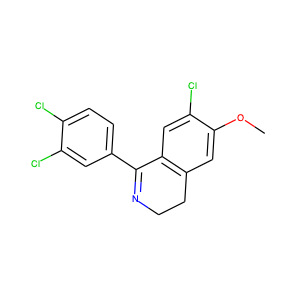

In [22]:
# Read in drugs and proteins
drugs_ = json.load(open(LOCAL_KIBA_PATH), object_pairs_hook=OrderedDict)
smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in drugs_.values()])

print('SMILES string:')
print(smiles[0])
print('\nOriginal molecule:')
mols = MolFromSmiles(smiles[0])

featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
graph_data = featurizer.featurize(smiles)
print(graph_data[0])
Draw.MolToImage(mols)

In [107]:
# The codes in this cell are from section 10 of AM216

LOCAL_KIBA_PATH = '../data/mini_project_data/data/kiba/'
LOCAL_DAVIS_PATH = '../data/GraphDTA_davis/'
G_PATH = './drive/MyDrive/Colab Notebooks/Drug Binding'
def smiles_graph(path):
    drugs_ = json.load(open(path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
    smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in drugs_.values()])

    # print('\nOriginal molecule:')
    mols = MolFromSmiles(smiles[0])
    # Draw.MolToImage(mols)
    featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
    graph_data = featurizer.featurize(smiles)
    return smiles, graph_data

In [121]:
# Convert SMILES to graphs
smiles_kiba, convmol_kiba = smiles_graph(LOCAL_KIBA_PATH)
smiles_davis, convmol_davis = smiles_graph(LOCAL_DAVIS_PATH)

In [181]:
convmol_kiba

array([<deepchem.feat.mol_graphs.ConvMol object at 0x7f845d8f07c0>,
       <deepchem.feat.mol_graphs.ConvMol object at 0x7f845d8f03a0>, ...,
      dtype=object)

In [109]:
# Read in affinity data
affinity_kiba = np.array(pickle.load(open(LOCAL_KIBA_PATH + "Y","rb"), encoding='latin1'))
affinity_davis = np.array(pickle.load(open(LOCAL_DAVIS_PATH + "Y","rb"), encoding='latin1'))



In [130]:
# Read in train/test fold  
train_fold = json.load(open(LOCAL_KIBA_PATH + "folds/train_fold_setting1.txt"))
train_fold = [ee for e in train_fold for ee in e ]    
test_fold = json.load(open(LOCAL_KIBA_PATH + "folds/test_fold_setting1.txt"))


In [106]:
# Create data generator to convert ConvMol to input for TF
def data_generator(dataset):
  for multiConvMol in graphs_kiba:
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    labels = [np.array([1.0]*10 + [0.0]*11)]
    weights = labels
    yield (inputs, labels, weights)

multiConvMol = graphs_davis[0]
inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    inputs.append(multiConvMol.get_deg_adjacency_lists()[i])

In [105]:
inputs, labels, weights = data_generator(graphs_kiba)
print(len(inputs), inputs[0].shape, labels[0].shape, weights[0].shape)

13 (21, 75) (21,) (21,)


In [60]:
inputs[0].shape

(21, 75)

In [168]:
def adj2matr(raw_a):
    len_a = len(raw_a)
    matr = np.zeros((len_a, len_a))
    for i in range(len_a):
        for j in raw_a[i]:
            matr[i, j] = 1
    return sp.csr_matrix(matr)

In [170]:
# convmol to matrices
nodes_davis = []
adj_davis = []
for i in range(len(convmol_davis)):
    nodes_davis.append(convmol_davis[i].get_atom_features())
    adj_davis.append(adj2matr(convmol_davis[i].get_adjacency_list()))
# nodes_davis = np.array(nodes_davis)
# adj_davis = np.array(adj_davis)
temp_y_davis = np.array([1]*30 + [0]*38)

In [156]:
print(len(graphs_davis), graphs_davis[0].get_atom_features())

68 [[1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [154]:
np.array(graphs_davis[0].get_adjacency_list())

<ipython-input-154-d7eaa99b5497>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(graphs_davis[0].get_adjacency_list())


array([list([8]), list([34]), list([11]), list([22]), list([17, 7]),
       list([33, 17]), list([9, 27]), list([4, 20]), list([0, 21]),
       list([22, 6]), list([30, 34]), list([29, 2]), list([13, 14]),
       list([25, 12]), list([12, 15]), list([14, 23]), list([21, 30]),
       list([5, 4]), list([31, 19, 28]), list([18, 24, 32]),
       list([7, 32, 33]), list([8, 16, 29]), list([26, 3, 9]),
       list([15, 31, 25]), list([34, 33, 19]), list([28, 13, 23]),
       list([27, 28, 22]), list([32, 26, 6]), list([26, 25, 18]),
       list([34, 11, 21]), list([16, 10, 31]), list([23, 18, 30]),
       list([20, 27, 19]), list([24, 5, 20]), list([10, 1, 29, 24])],
      dtype=object)

In [155]:
print(len(graphs_davis), graphs_davis[0].get_adjacency_list())

68 [[8], [34], [11], [22], [17, 7], [33, 17], [9, 27], [4, 20], [0, 21], [22, 6], [30, 34], [29, 2], [13, 14], [25, 12], [12, 15], [14, 23], [21, 30], [5, 4], [31, 19, 28], [18, 24, 32], [7, 32, 33], [8, 16, 29], [26, 3, 9], [15, 31, 25], [34, 33, 19], [28, 13, 23], [27, 28, 22], [32, 26, 6], [26, 25, 18], [34, 11, 21], [16, 10, 31], [23, 18, 30], [20, 27, 19], [24, 5, 20], [10, 1, 29, 24]]


In [162]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data import Dataset, DisjointLoader, Graph
import scipy.sparse as sp

class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [171]:

graphs_davis = [Graph(x=x, a=a, y=y) for x, a, y in zip(nodes_davis, adj_davis, temp_y_davis)]

In [172]:
from spektral.data import BatchLoader

loader = BatchLoader(graphs_davis, batch_size=32)
loader.load()

In [178]:
model = MyFirstGNN(32, 2)
model.compile('adam', 'L2Loss')
model.fit(loader.load(), steps_per_epoch=loader.steps_per_epoch, epochs=10)

StopIteration: 

In [175]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers

batch_size = 100

# Define a Graph Convolution Model
class MyGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(MyGraphConvModel, self).__init__()
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    # self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(8)
    # self.logits = layers.Reshape((n_tasks, 2))
    self.dense = layers.Dense(1)

  def call(self, inputs):
    gc1_output = self.gc1(inputs)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

    gc2_output = self.gc2([gp1_output] + inputs[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    batch_norm3_output = self.dense2(batch_norm3_output)
    # readout_output = self.readout([batch_norm3_output] + inputs[1:])

    # logits_output = self.logits(self.dense2(batch_norm3_output))
    return self.dense(batch_norm3_output)

In [97]:
# Make apply the DeepChem wrapper 
model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.L2Loss())

In [98]:
model.fit_generator(data_generator(graphs_kiba))

/Users/lihongzhang/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/my_graph_conv_model_6/graph_pool_13/Reshape_11:0", shape=(4,), dtype=int32), values=Tensor("gradient_tape/my_graph_conv_model_6/graph_pool_13/Reshape_10:0", shape=(4, 128), dtype=float32), dense_shape=Tensor("gradient_tape/my_graph_conv_model_6/graph_pool_13/Cast_3:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/lihongzhang/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/my_graph_conv_model_6/graph_pool_13/Reshape_14:0", shape=(18,), dtype=int32), values=Tensor("gradient_tape/my_graph_conv_model_6/graph_pool_13/Reshape_13:0", shape=(18, 128), dtype=float32), dense_shape=Te

InvalidArgumentError:  Incompatible shapes: [20,1] vs. [21,1]
	 [[node gradient_tape/sub/BroadcastGradientArgs (defined at /Users/lihongzhang/opt/anaconda3/lib/python3.8/site-packages/deepchem/models/keras_model.py:474) ]] [Op:__inference_apply_gradient_for_batch_17485]

Function call stack:
apply_gradient_for_batch


In [28]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

RDKit WARNING: [17:45:38] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:45:55] WARNING: not removing hydrogen atom without neighbors


In [43]:
datasets[0].iterbatches(batch_size = 32, epochs = 1)

<generator object DiskDataset._iterbatches_from_shards.<locals>.iterate at 0x7f84284f84a0>